# SNOTEL Data Access

This notebook allows for easy access to snow depths and SWE from the Snow Telemetry (SNOTEL) network. A simple example is used to show quick access to SNOTEL data over Alexander Lake, AK using the `easysnowdata` package.

Credit: Eric Gagliano (egagli@uw.edu) for the `easysnowdata` package, which in turn uses `ulmo` to access SNOTEL data. Note that development of `ulmo` has stalled, so SNOTEL sites developed after 2021 are not accessible through this method.

In [1]:
!pip install metloom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1


In [3]:
# import the pointdata classes
from metloom.pointdata import (
    PointData, CDECPointData, SnotelPointData, MesowestPointData, USGSPointData
)
# import the variable classes
from metloom.variables import (
    SensorDescription, CdecStationVariables, SnotelVariables, MesowestVariables, USGSVariables
)

In [13]:
from datetime import datetime
import pandas as pd
import geopandas as gpd
from pathlib import Path

In [16]:
# Find your area
sf_path = Path("/home/jovyan/shared-public/SnowPit/cffl_lidar_box.geojson").expanduser()
sf = gpd.read_file(str(sf_path))
sf["name"] = ["FLCF"]
variables = [SnotelPointData.ALLOWED_VARIABLES.SNOWDEPTH]

In [18]:
# Find all the points in the area for our variables
points = SnotelPointData.points_from_geometry(sf, variables)

In [20]:
# buffer - add buffer (in degrees) to extents
print(SnotelPointData.points_from_geometry(sf, variables, buffer=0.5).points)

[SnotelPointData('1302:AK:SNTL', 'Creamers Field')]


In [23]:
# plot the shapefile
m = sf.explore(
    tooltip=False, color="grey", highlight=False, tiles="Esri.WorldImagery",
    style_kwds={"opacity": 0.2}, popup=["name"]
)
# plot the points on top of the shapefile
df = points.to_dataframe()
df.explore(m=m, tooltip=["name", "id"], color="red", marker_kwds={"radius":4})

In [5]:
SnotelVariables.SNOWDEPTH.name

'SNOWDEPTH'

In [6]:
pt = SnotelPointData("1302:AK:SNTL", "Creamer's Field")

In [10]:
start_date = datetime(2022, 3, 1)
end_date = datetime(2023, 4, 1)

variables = [pt.ALLOWED_VARIABLES.SNOWDEPTH]
df = pt.get_daily_data(start_date, end_date, variables)

<Axes: xlabel='datetime'>

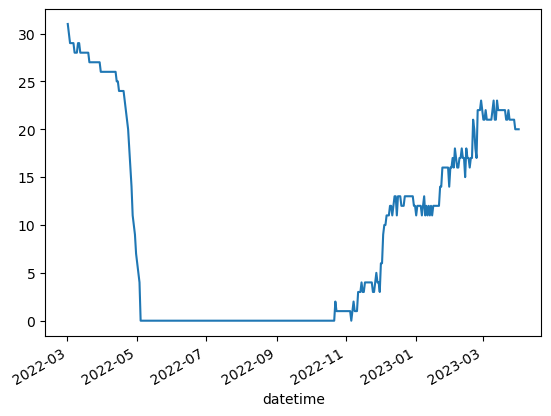

In [12]:
df.reset_index().set_index("datetime")["SNOWDEPTH"].plot()